In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from scipy.io.matlab.mio import loadmat, savemat
import numpy as np
from PIL import Image
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn import preprocessing


C:\Users\xia\AppData\Local\Temp\ipykernel_18472\1157685092.py:8: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
C:\Users\xia\AppData\Local\Temp\ipykernel_18472\1157685092.py:8: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


In [2]:
def getData(filename1,filename2, remove_duplicata = True):
    df1 = pd.read_csv(filename1)
    df1.drop(df1.columns[len(df1.columns)-1], axis=1,inplace = True)
    df2 = pd.read_csv(filename2)
    X1 = df1.to_numpy()
    X2 = df2.to_numpy()
    s1, s2 = X1.shape[1], X2.shape[1]
    X11, X12 = X1[:,s1//2:], X1[:,:s1//2]
    X21, X22 = X2[:,s1//2:], X2[:,:s1//2]
    X = np.hstack((X11,X21,X12,X22))
    return X[:,:-1], X[:,-1]

In [3]:
def tmp(filename, remove_duplicata = True):
    with open(filename) as f:
        df = pd.read_csv(f)
        if remove_duplicata:
            df = df.drop_duplicates()
        X = df.to_numpy()
    return X[:,:-1], X[:,-1]


In [22]:
X,Y = getData("tmpdata/dataBow.csv","tmpdata/dataSelection.csv")
X=X.astype("int64")
X=np.unique(X,axis=0,return_index=True)
X,index = X
Y = Y[index]

In [23]:
X.shape

(8630, 302)

In [24]:

le = preprocessing.LabelEncoder()

tmp = X[:,X.shape[1]//2:]
anotherX = X[:,:X.shape[1]//2]-tmp
#anotherX = normalize(anotherX)
le.fit(Y)
Ynum = le.transform(Y)

In [25]:
dataset = torch.utils.data.TensorDataset(torch.Tensor(X),torch.Tensor(Ynum).type(torch.LongTensor))

In [26]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_tanH_stack = nn.Sequential(
            nn.Linear(302, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, len(np.unique(Y)))
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_tanH_stack(x)
        return logits


In [36]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [37]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [40]:
epochs = 500

model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


# Create the data loaders for training and validation
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=200,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=200,
    shuffle=False
)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.632772  [  200/ 6904]
Test Error: 
 Accuracy: 41.7%, Avg loss: 1.487697 

Epoch 2
-------------------------------
loss: 1.516116  [  200/ 6904]
Test Error: 
 Accuracy: 41.0%, Avg loss: 1.450398 

Epoch 3
-------------------------------
loss: 1.326592  [  200/ 6904]
Test Error: 
 Accuracy: 44.7%, Avg loss: 1.269703 

Epoch 4
-------------------------------
loss: 1.301941  [  200/ 6904]
Test Error: 
 Accuracy: 45.5%, Avg loss: 1.290970 

Epoch 5
-------------------------------
loss: 1.224572  [  200/ 6904]
Test Error: 
 Accuracy: 49.9%, Avg loss: 1.138179 

Epoch 6
-------------------------------
loss: 1.058250  [  200/ 6904]
Test Error: 
 Accuracy: 49.0%, Avg loss: 1.163664 

Epoch 7
-------------------------------
loss: 1.103610  [  200/ 6904]
Test Error: 
 Accuracy: 51.2%, Avg loss: 1.112912 

Epoch 8
-------------------------------
loss: 0.977188  [  200/ 6904]
Test Error: 
 Accuracy: 49.8%, Avg loss: 1.107563 

Epoch 9
----------------

Test Error: 
 Accuracy: 66.3%, Avg loss: 0.773332 

Epoch 69
-------------------------------
loss: 0.747758  [  200/ 6904]
Test Error: 
 Accuracy: 68.9%, Avg loss: 0.732331 

Epoch 70
-------------------------------
loss: 0.698228  [  200/ 6904]
Test Error: 
 Accuracy: 70.6%, Avg loss: 0.643347 

Epoch 71
-------------------------------
loss: 0.651881  [  200/ 6904]
Test Error: 
 Accuracy: 70.6%, Avg loss: 0.624193 

Epoch 72
-------------------------------
loss: 0.584921  [  200/ 6904]
Test Error: 
 Accuracy: 66.3%, Avg loss: 0.757099 

Epoch 73
-------------------------------
loss: 0.803274  [  200/ 6904]
Test Error: 
 Accuracy: 63.7%, Avg loss: 0.789524 

Epoch 74
-------------------------------
loss: 0.699121  [  200/ 6904]
Test Error: 
 Accuracy: 60.4%, Avg loss: 0.828361 

Epoch 75
-------------------------------
loss: 0.742091  [  200/ 6904]
Test Error: 
 Accuracy: 70.5%, Avg loss: 0.662929 

Epoch 76
-------------------------------
loss: 0.642424  [  200/ 6904]
Test Error: 
 Ac

Test Error: 
 Accuracy: 60.5%, Avg loss: 0.900727 

Epoch 136
-------------------------------
loss: 0.880336  [  200/ 6904]
Test Error: 
 Accuracy: 68.9%, Avg loss: 0.690642 

Epoch 137
-------------------------------
loss: 0.521399  [  200/ 6904]
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.642668 

Epoch 138
-------------------------------
loss: 0.618318  [  200/ 6904]
Test Error: 
 Accuracy: 73.2%, Avg loss: 0.558270 

Epoch 139
-------------------------------
loss: 0.485511  [  200/ 6904]
Test Error: 
 Accuracy: 59.7%, Avg loss: 0.923409 

Epoch 140
-------------------------------
loss: 0.825914  [  200/ 6904]
Test Error: 
 Accuracy: 71.7%, Avg loss: 0.630008 

Epoch 141
-------------------------------
loss: 0.625521  [  200/ 6904]
Test Error: 
 Accuracy: 73.3%, Avg loss: 0.619701 

Epoch 142
-------------------------------
loss: 0.672843  [  200/ 6904]
Test Error: 
 Accuracy: 70.1%, Avg loss: 0.673296 

Epoch 143
-------------------------------
loss: 0.627935  [  200/ 6904]
Test Err

Test Error: 
 Accuracy: 73.6%, Avg loss: 0.557350 

Epoch 203
-------------------------------
loss: 0.517814  [  200/ 6904]
Test Error: 
 Accuracy: 74.1%, Avg loss: 0.578952 

Epoch 204
-------------------------------
loss: 0.558063  [  200/ 6904]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.509771 

Epoch 205
-------------------------------
loss: 0.422993  [  200/ 6904]
Test Error: 
 Accuracy: 73.5%, Avg loss: 0.541327 

Epoch 206
-------------------------------
loss: 0.463999  [  200/ 6904]
Test Error: 
 Accuracy: 73.2%, Avg loss: 0.546813 

Epoch 207
-------------------------------
loss: 0.445972  [  200/ 6904]
Test Error: 
 Accuracy: 73.1%, Avg loss: 0.584869 

Epoch 208
-------------------------------
loss: 0.529107  [  200/ 6904]
Test Error: 
 Accuracy: 76.4%, Avg loss: 0.570407 

Epoch 209
-------------------------------
loss: 0.427047  [  200/ 6904]
Test Error: 
 Accuracy: 75.1%, Avg loss: 0.567340 

Epoch 210
-------------------------------
loss: 0.527386  [  200/ 6904]
Test Err

Test Error: 
 Accuracy: 64.6%, Avg loss: 0.980603 

Epoch 270
-------------------------------
loss: 0.898520  [  200/ 6904]
Test Error: 
 Accuracy: 70.6%, Avg loss: 0.727671 

Epoch 271
-------------------------------
loss: 0.483045  [  200/ 6904]
Test Error: 
 Accuracy: 82.4%, Avg loss: 0.476781 

Epoch 272
-------------------------------
loss: 0.364712  [  200/ 6904]
Test Error: 
 Accuracy: 67.7%, Avg loss: 0.742164 

Epoch 273
-------------------------------
loss: 0.700939  [  200/ 6904]
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.567188 

Epoch 274
-------------------------------
loss: 0.558697  [  200/ 6904]
Test Error: 
 Accuracy: 72.1%, Avg loss: 0.560066 

Epoch 275
-------------------------------
loss: 0.540456  [  200/ 6904]
Test Error: 
 Accuracy: 71.6%, Avg loss: 0.650426 

Epoch 276
-------------------------------
loss: 0.628923  [  200/ 6904]
Test Error: 
 Accuracy: 65.9%, Avg loss: 0.700676 

Epoch 277
-------------------------------
loss: 0.622530  [  200/ 6904]
Test Err

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.537606 

Epoch 337
-------------------------------
loss: 0.483574  [  200/ 6904]
Test Error: 
 Accuracy: 74.2%, Avg loss: 0.622962 

Epoch 338
-------------------------------
loss: 0.490965  [  200/ 6904]
Test Error: 
 Accuracy: 71.5%, Avg loss: 0.648449 

Epoch 339
-------------------------------
loss: 0.580567  [  200/ 6904]
Test Error: 
 Accuracy: 76.1%, Avg loss: 0.575830 

Epoch 340
-------------------------------
loss: 0.486146  [  200/ 6904]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.376390 

Epoch 341
-------------------------------
loss: 0.255259  [  200/ 6904]
Test Error: 
 Accuracy: 74.7%, Avg loss: 0.557999 

Epoch 342
-------------------------------
loss: 0.396109  [  200/ 6904]
Test Error: 
 Accuracy: 76.4%, Avg loss: 0.530345 

Epoch 343
-------------------------------
loss: 0.448114  [  200/ 6904]
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.415731 

Epoch 344
-------------------------------
loss: 0.382341  [  200/ 6904]
Test Err

Test Error: 
 Accuracy: 75.7%, Avg loss: 0.572742 

Epoch 404
-------------------------------
loss: 0.423841  [  200/ 6904]
Test Error: 
 Accuracy: 75.4%, Avg loss: 0.570648 

Epoch 405
-------------------------------
loss: 0.487252  [  200/ 6904]
Test Error: 
 Accuracy: 73.2%, Avg loss: 0.574240 

Epoch 406
-------------------------------
loss: 0.472931  [  200/ 6904]
Test Error: 
 Accuracy: 72.7%, Avg loss: 0.592017 

Epoch 407
-------------------------------
loss: 0.485826  [  200/ 6904]
Test Error: 
 Accuracy: 70.6%, Avg loss: 0.678983 

Epoch 408
-------------------------------
loss: 0.663973  [  200/ 6904]
Test Error: 
 Accuracy: 75.3%, Avg loss: 0.548954 

Epoch 409
-------------------------------
loss: 0.436347  [  200/ 6904]
Test Error: 
 Accuracy: 73.6%, Avg loss: 0.581730 

Epoch 410
-------------------------------
loss: 0.500818  [  200/ 6904]
Test Error: 
 Accuracy: 69.9%, Avg loss: 0.735978 

Epoch 411
-------------------------------
loss: 0.550439  [  200/ 6904]
Test Err

Test Error: 
 Accuracy: 63.7%, Avg loss: 0.918827 

Epoch 471
-------------------------------
loss: 0.896144  [  200/ 6904]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.521785 

Epoch 472
-------------------------------
loss: 0.433560  [  200/ 6904]
Test Error: 
 Accuracy: 76.1%, Avg loss: 0.525118 

Epoch 473
-------------------------------
loss: 0.390350  [  200/ 6904]
Test Error: 
 Accuracy: 65.9%, Avg loss: 0.722631 

Epoch 474
-------------------------------
loss: 0.640021  [  200/ 6904]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.427363 

Epoch 475
-------------------------------
loss: 0.332276  [  200/ 6904]
Test Error: 
 Accuracy: 74.2%, Avg loss: 0.570381 

Epoch 476
-------------------------------
loss: 0.510556  [  200/ 6904]
Test Error: 
 Accuracy: 75.1%, Avg loss: 0.536423 

Epoch 477
-------------------------------
loss: 0.388728  [  200/ 6904]
Test Error: 
 Accuracy: 68.3%, Avg loss: 0.710970 

Epoch 478
-------------------------------
loss: 0.620244  [  200/ 6904]
Test Err

In [13]:
extraEp = 100

for t in range(extraEp):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.604729  [  200/ 8645]
Test Error: 
 Accuracy: 70.4%, Avg loss: 0.672387 

Epoch 2
-------------------------------
loss: 0.689742  [  200/ 8645]
Test Error: 
 Accuracy: 76.1%, Avg loss: 0.597241 

Epoch 3
-------------------------------
loss: 0.420356  [  200/ 8645]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.565831 

Epoch 4
-------------------------------
loss: 0.530844  [  200/ 8645]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.608115 

Epoch 5
-------------------------------
loss: 0.505167  [  200/ 8645]
Test Error: 
 Accuracy: 74.4%, Avg loss: 0.650400 

Epoch 6
-------------------------------
loss: 0.542499  [  200/ 8645]
Test Error: 
 Accuracy: 68.9%, Avg loss: 0.733525 

Epoch 7
-------------------------------
loss: 0.744621  [  200/ 8645]
Test Error: 
 Accuracy: 71.3%, Avg loss: 0.718155 

Epoch 8
-------------------------------
loss: 0.636851  [  200/ 8645]
Test Error: 
 Accuracy: 74.3%, Avg loss: 0.618165 

Epoch 9
----------------

loss: 0.544852  [  200/ 8645]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.553060 

Epoch 69
-------------------------------
loss: 0.504248  [  200/ 8645]
Test Error: 
 Accuracy: 73.2%, Avg loss: 0.713572 

Epoch 70
-------------------------------
loss: 0.573710  [  200/ 8645]
Test Error: 
 Accuracy: 70.5%, Avg loss: 0.721494 

Epoch 71
-------------------------------
loss: 0.617790  [  200/ 8645]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.532886 

Epoch 72
-------------------------------
loss: 0.535188  [  200/ 8645]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.535257 

Epoch 73
-------------------------------
loss: 0.480526  [  200/ 8645]
Test Error: 
 Accuracy: 76.8%, Avg loss: 0.628244 

Epoch 74
-------------------------------
loss: 0.535136  [  200/ 8645]
Test Error: 
 Accuracy: 81.8%, Avg loss: 0.478306 

Epoch 75
-------------------------------
loss: 0.432759  [  200/ 8645]
Test Error: 
 Accuracy: 82.0%, Avg loss: 0.484833 

Epoch 76
-------------------------------
loss: 0.440706  

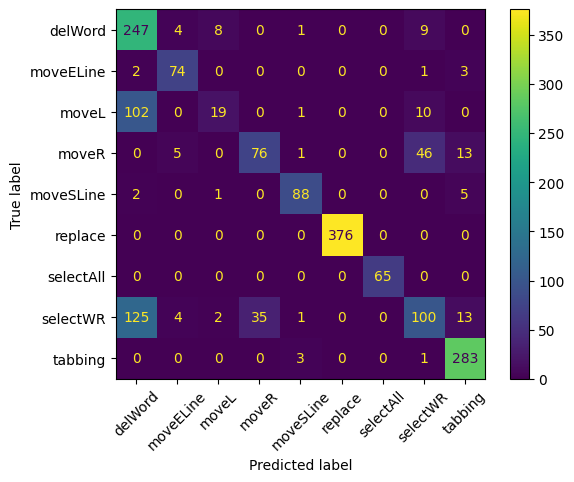

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Used to calculate the confusion matrix
y_true = []
y_pred = []
for X,y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())

    X, y = X.to(device), y.to(device)
    pred = model(X)
    y_pred.extend(pred.argmax(1).data.cpu().numpy())
    
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(Y))
disp.plot()
plt.xticks(rotation=45)
plt.show()


Accuracy avant:  0.8065934065934066
Accuracy après:  0.9799451129406798
pred restantes:  4737
pred supprimees:  3908
pourcentage restant:  0.5479467900520532


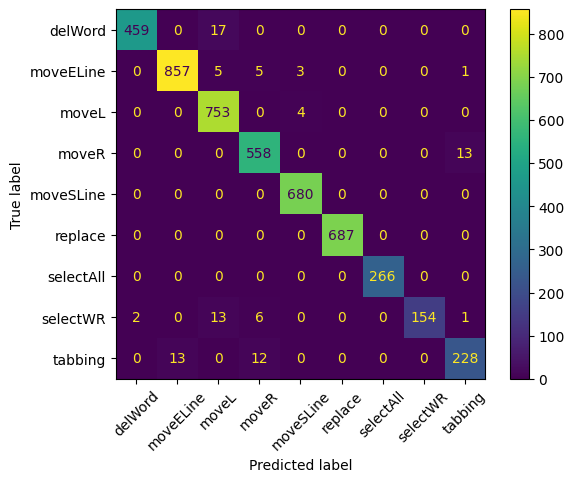

In [15]:

#Used to calculate the confusion matrix
y_true = []
y_pred = []

for X, y in train_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.8
indices = y_pred.max(1) > seuil

print("Accuracy avant: ", np.where(y_pred.argmax(1) == y_true, 1, 0).mean())
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]
print("Accuracy après: ", np.where(y_pred == y_true, 1, 0).mean())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = np.unique(Y))
disp.plot()

print("pred restantes: ", sum(indices))
print("pred supprimees: ", sum(False == indices))
print("pourcentage restant: ", sum(indices)/len(indices))
plt.xticks(rotation=45)

plt.show()

Accuracy avant:  0.8020735155513666
Accuracy après:  0.9749631811487481
pred restantes:  1358
pred supprimees:  764
pourcentage restant:  0.6399622997172478


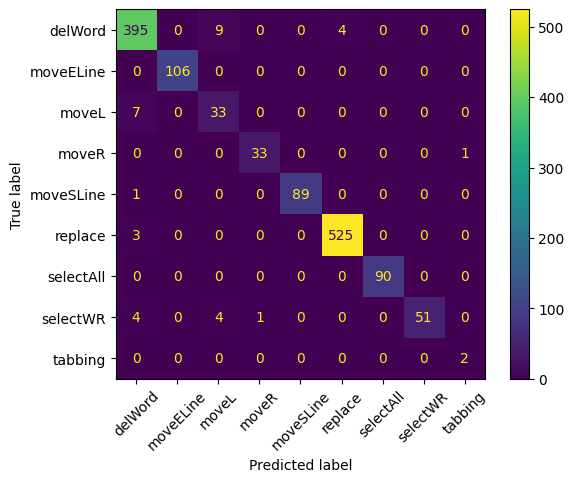

In [43]:

#Used to calculate the confusion matrix
y_true = []
y_pred = []

for X, y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.80
indices = y_pred.max(1) > seuil

print("Accuracy avant: ", np.where(y_pred.argmax(1) == y_true, 1, 0).mean())
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]
print("Accuracy après: ", np.where(y_pred == y_true, 1, 0).mean())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = np.unique(Y))
disp.plot()

print("pred restantes: ", sum(indices))
print("pred supprimees: ", sum(False == indices))
print("pourcentage restant: ", sum(indices)/len(indices))
plt.xticks(rotation=45)

plt.show()

In [42]:
torch.save(model.state_dict(), "./models/model")